['GRBALPHA_20241017T082528_pickled.bin', 'GRBALPHA_20241017T224535_pickled.bin', 'GRBALPHA_20241018T001903_pickled.bin', 'GRBALPHA_20241018T110034_pickled.bin', 'GRBALPHA_20241018T221326_pickled.bin', 'GRBALPHA_20241018T234627_pickled.bin', 'GRBALPHA_20241019T085324_pickled.bin', 'GRBALPHA_20241019T102657_pickled.bin', 'GRBALPHA_20241019T214126_pickled.bin', 'GRBALPHA_20241020T224123_pickled.bin', 'GRBALPHA_20241022T230911_pickled.bin', 'GRBALPHA_20241023T094901_pickled.bin', 'GRBALPHA_20241024T105037_pickled.bin', 'GRBALPHA_20241025T230331_pickled.bin', 'GRBALPHA_20241026T223029_pickled.bin', 'GRBALPHA_20241027T000340_pickled.bin', 'GRBALPHA_20241027T233012_pickled.bin', 'GRBALPHA_20241028T083709_pickled.bin', 'GRBALPHA_20241028T100958_pickled.bin', 'GRBALPHA_20241028T225645_pickled.bin', 'GRBALPHA_20241029T003018_pickled.bin', 'GRBALPHA_20241030T090242_pickled.bin', 'GRBALPHA_20241030T103630_pickled.bin', 'GRBALPHA_20241030T232232_pickled.bin', 'GRBALPHA_20241031T005632_pickled.bin',

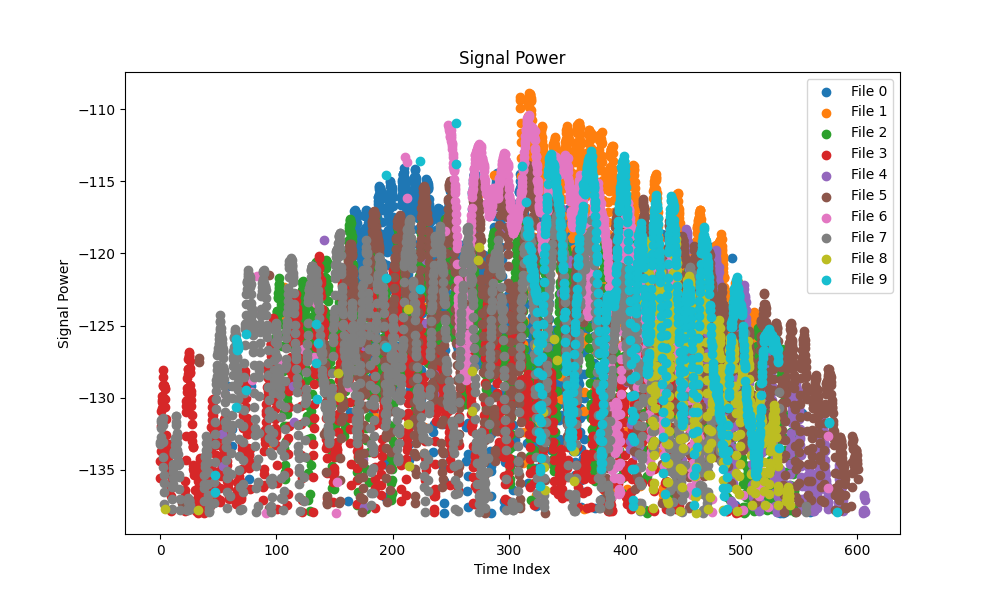

In [7]:
%matplotlib widget
#remember to pip install ipympl
import matplotlib.pyplot as plt
import noisy_moose as nm  # Ensure noisy_moose is installed
import json
import pickle
import numpy as np
import os


# Define the data path
data_path = 'C:/Users/StoreElberg/OneDrive - Aalborg Universitet/Git3/no_waterfall/active/'

# Get all files in the directory
files = os.listdir(data_path)

# Filter files starting with 'GRBALPHA'
files = [f for f in files if f.startswith('GRBALPHA')]

# Print the filtered files
print(files)

def calculate_pointing_error(set_azimuth, set_elevation, azimuth, elevation):
    """
    Calculate the pointing error given reference (set) and measured azimuth and elevation.
    
    Parameters:
        set_azimuth (array-like): Reference azimuth values in degrees.
        set_elevation (array-like): Reference elevation values in degrees.
        azimuth (array-like): Measured azimuth values in degrees.
        elevation (array-like): Measured elevation values in degrees.
    
    Returns:
        np.ndarray: Pointing error for each pair of reference and measured angles in degrees.
    """
    # Convert degrees to radians
    set_azimuth_rad = np.radians(set_azimuth)
    set_elevation_rad = np.radians(set_elevation)
    azimuth_rad = np.radians(azimuth)
    elevation_rad = np.radians(elevation)
    
    # Compute the pointing error using the great-circle distance formula
    pointing_error_rad = np.arccos(
        np.sin(set_elevation_rad) * np.sin(elevation_rad) +
        np.cos(set_elevation_rad) * np.cos(elevation_rad) * np.cos(azimuth_rad - set_azimuth_rad)
    )
    
    # Convert the pointing error back to degrees
    pointing_error_deg = np.degrees(pointing_error_rad)
    return pointing_error_deg

def unpickle(file):
    """Unpickles the given file from data_path."""
    try:
        with open(data_path + file, 'rb') as f:
            dump = f.read()
        return pickle.loads(dump)
    except FileNotFoundError:
        print(f"File {file + '_pickled.bin'} not found. Skipping.")
        return None

def extract_features(prop_obj):
    """Extract multiple features from the given object."""
    if prop_obj is None:
        return None  # Skip if object is None

    # Calculate features
    pointing_error = calculate_pointing_error(
        prop_obj.station_obj.set_azimuth, 
        prop_obj.station_obj.set_elevation, 
        prop_obj.station_obj.azimuth, 
        prop_obj.station_obj.elevation
    )
    corrected_power = 10 * np.log10(prop_obj.noise_obj.signal_abs) - prop_obj.station_obj.fspl

    # Features
    features = [
        prop_obj.time_ax,                  # Time (0)
        prop_obj.noise_obj.signal_abs,     # Signal Power (1)
        prop_obj.station_obj.fspl,         # FSPL (2)
        prop_obj.station_obj.dist,         # Distance (3)
        prop_obj.station_obj.set_azimuth,  # Target azimuth (4)
        prop_obj.station_obj.set_elevation,# Target elevation (5)
        pointing_error,                    # Pointing error (6)
        prop_obj.noise_obj.noise,          # Noise power in W/Hz (7)
        corrected_power,                   # FSPL corrected signal power (8)
    ]

    # Find the maximum length
    max_length = max(len(feature) for feature in features)

    # Pad all features to the maximum length
    padded_features = [
        np.pad(feature, (0, max_length - len(feature)), constant_values=np.nan)
        for feature in features
    ]

    # Stack features column-wise
    return np.vstack(padded_features)


# Collect and process data
data_list = []
for f in files:  # Go through all files
    data: nm.prepping = unpickle(f)
    if data is not None:
        features = extract_features(data)
        if features is not None:
            data_list.append(features)

# Determine maximum length for padding
max_length = max(features.shape[1] for features in data_list)

# Pad the data for each file
padded_data = [
    np.pad(features, ((0, 0), (0, max_length - features.shape[1])), constant_values=np.nan) #all the ones which are not long enough are padded with nan, not ZERO or interpolated.
    for features in data_list
]

# Convert to a 3D numpy array: (file index, feature index, time index)
BAM = np.array(padded_data, dtype=np.float32)
print(f"BAM shape: {BAM.shape} (files, features, time)")

threshold=10**(-138/10) #-138dBm
print(threshold)
for file_idx in range(BAM.shape[0]):
    signal_power = BAM[file_idx, 1, :]  # Signal power is at feature index 1

    # Identify time indices where signal power is below the threshold
    mask = signal_power < threshold

    # Set all features at these time indices to NaN for the current file
    BAM[file_idx, :, mask] = np.nan

# Plot the first feature (e.g., signal power) for all files
plt.figure(figsize=(10, 6))
# for i in range(BAM.shape[0]):
for i in range(10):
    plt.scatter(BAM[i, 0], 10*np.log10(BAM[i, 1]), label=f'File {i}')  # Plot Feature 2 (Signal Power)
plt.xlabel('Time Index')
plt.ylabel('Signal Power')
plt.title('Signal Power')
plt.legend()
plt.show()

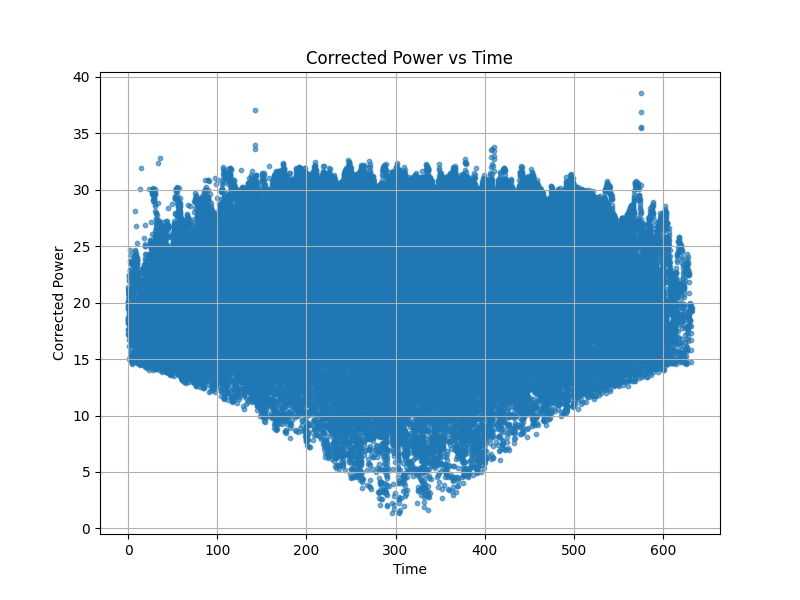

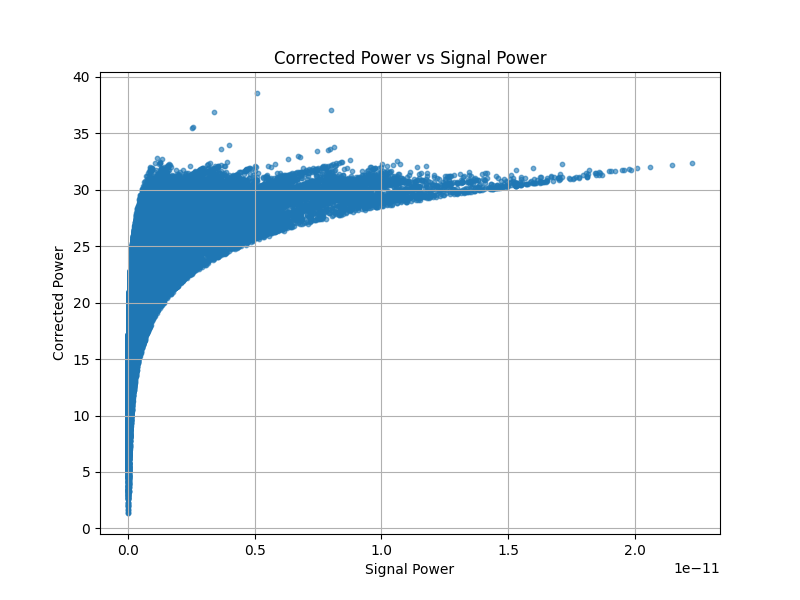

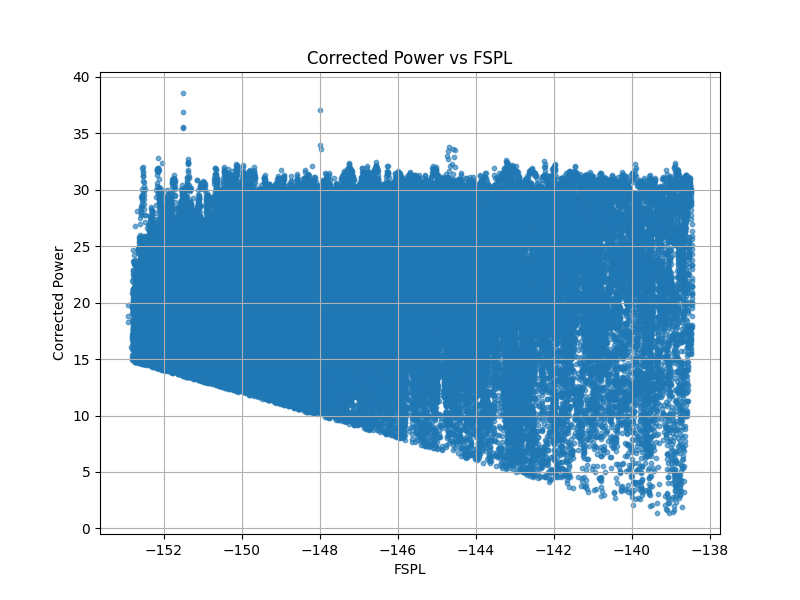

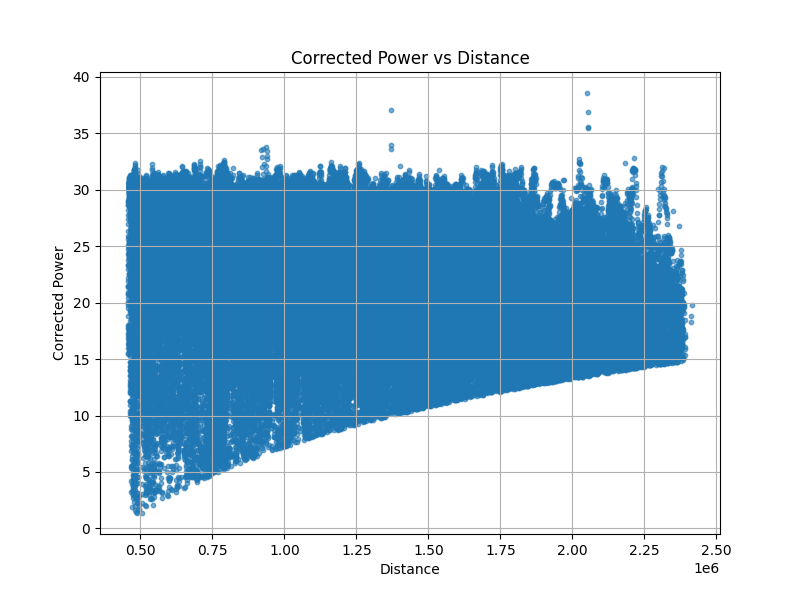

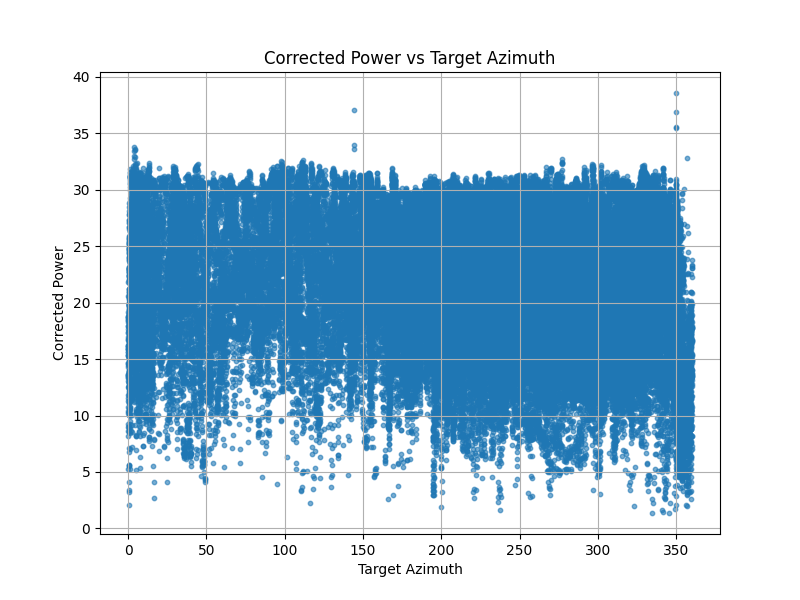

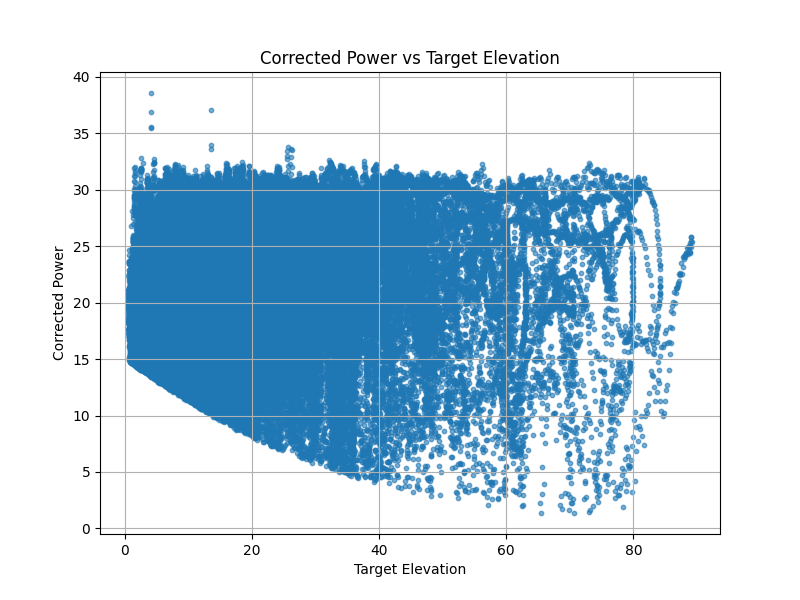

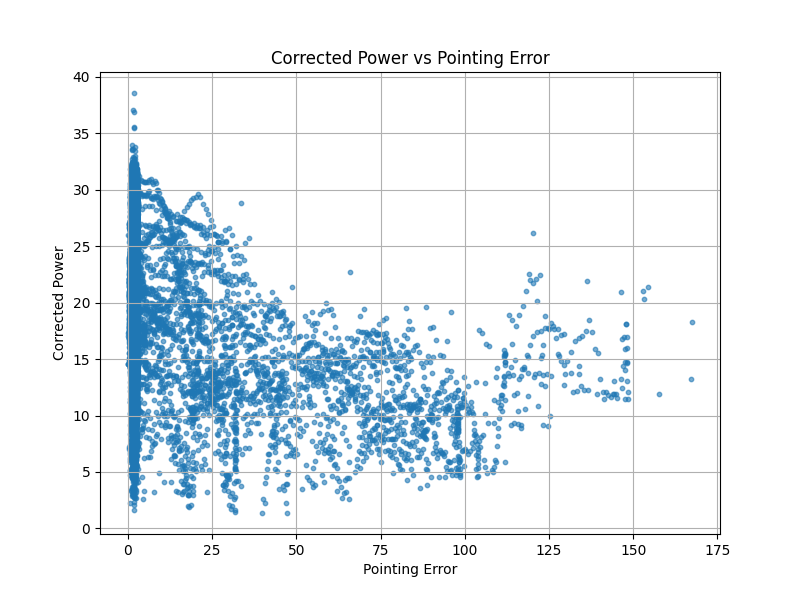

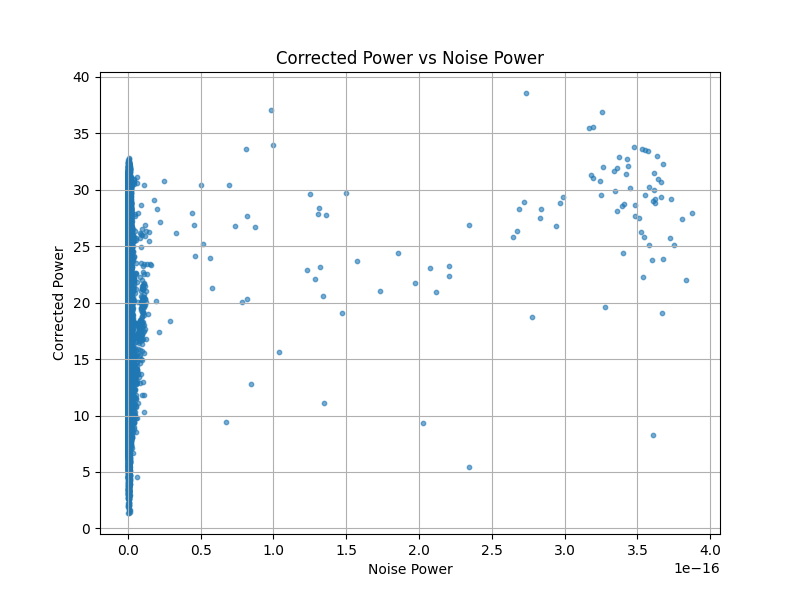

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Feature names for better visualization
feature_names = [
    "Time",                # 0
    "Signal Power",        # 1
    "FSPL",                # 2
    "Distance",            # 3
    "Target Azimuth",      # 4
    "Target Elevation",    # 5
    "Pointing Error",      # 6
    "Noise Power",         # 7
    "Corrected Power"      # 8
]

# Index of corrected power
corrected_power_idx = 8

# Iterate through all features except corrected_power
for idx, feature_name in enumerate(feature_names):
    if idx == corrected_power_idx:
        continue  # Skip corrected power itself

    # Extract the corrected power and the current feature
    corrected_power = BAM[:, corrected_power_idx, :].flatten()
    feature = BAM[:, idx, :].flatten()

    # Filter out NaN values for plotting
    valid_mask = ~np.isnan(corrected_power) & ~np.isnan(feature)
    corrected_power_valid = corrected_power[valid_mask]
    feature_valid = feature[valid_mask]

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(feature_valid, corrected_power_valid, alpha=0.6, s=10)
    plt.xlabel(feature_name)
    plt.ylabel("Corrected Power")
    plt.title(f"Corrected Power vs {feature_name}")
    plt.grid(True)
    plt.show()


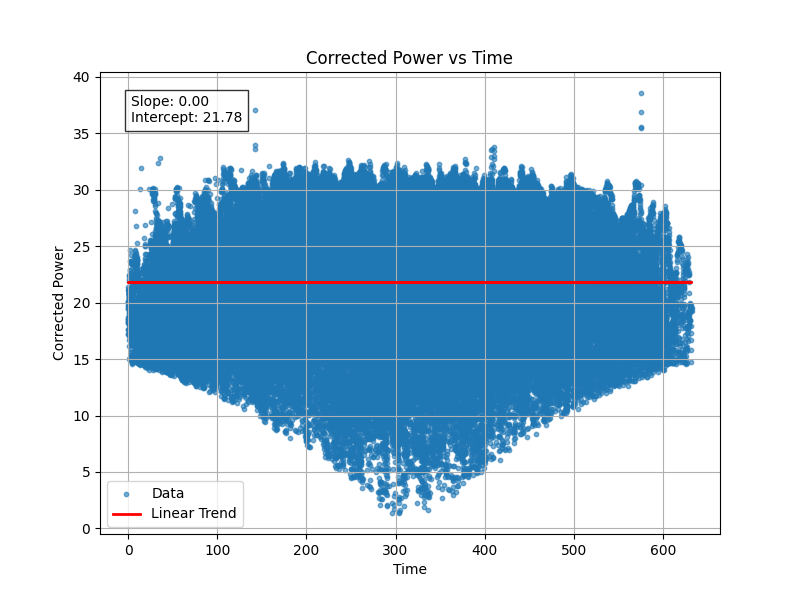

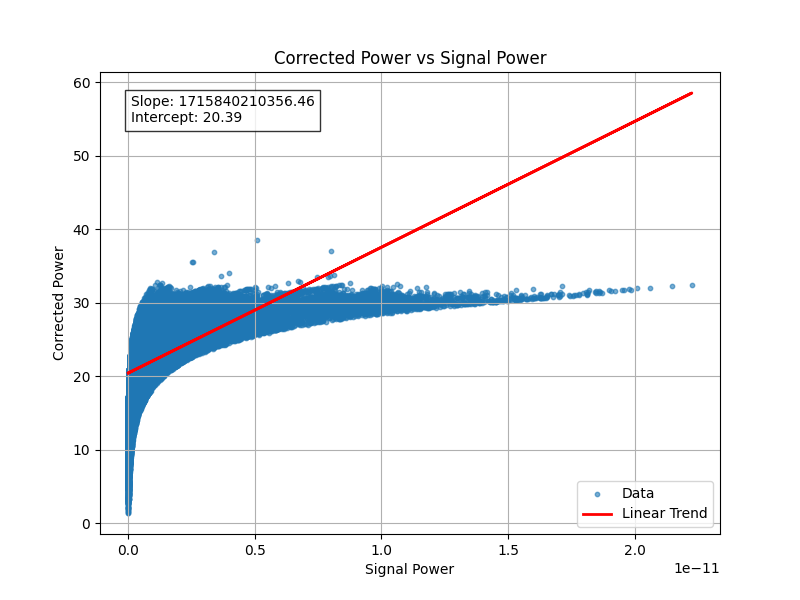

C:\Users\StoreElberg\AppData\Local\Temp\ipykernel_41892\4129174926.py:36: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(feature_valid, corrected_power_valid, 1)


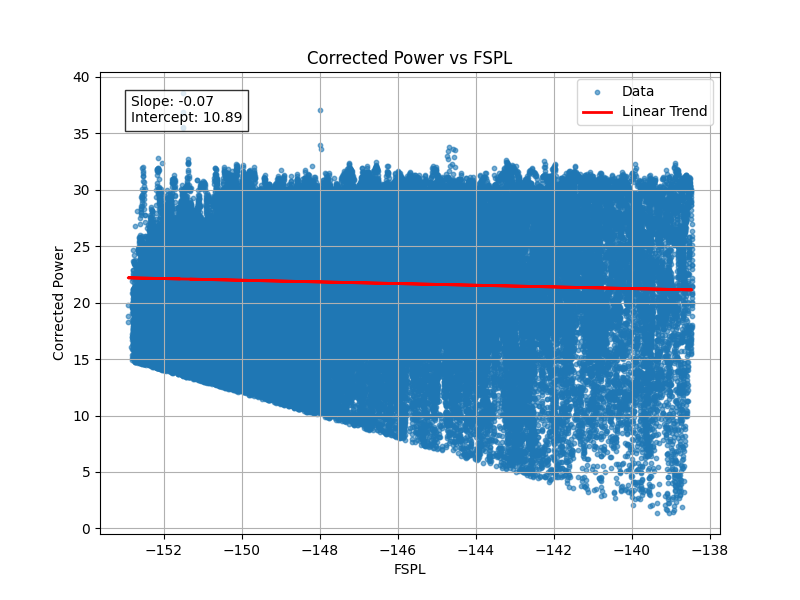

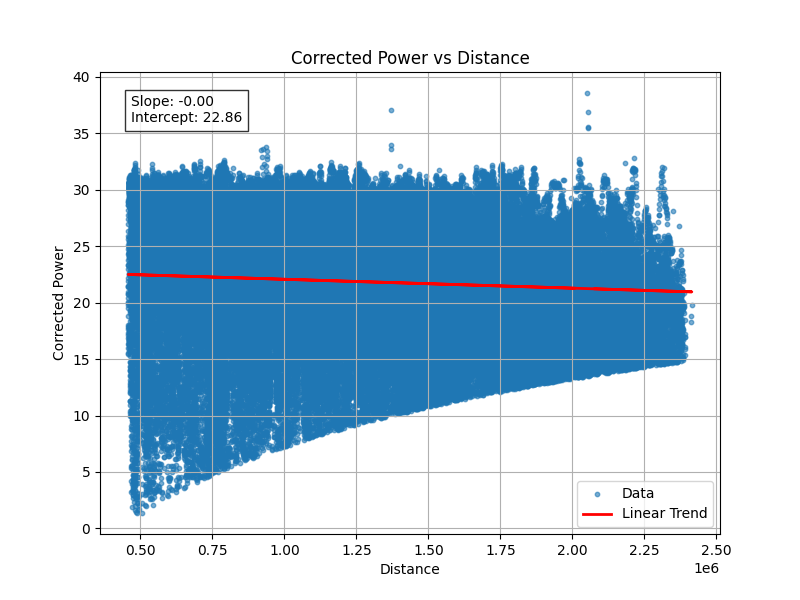

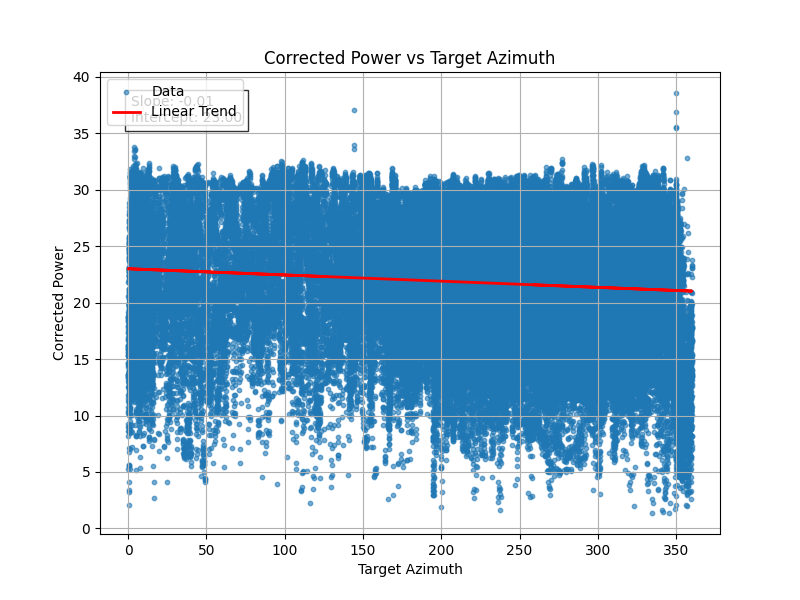

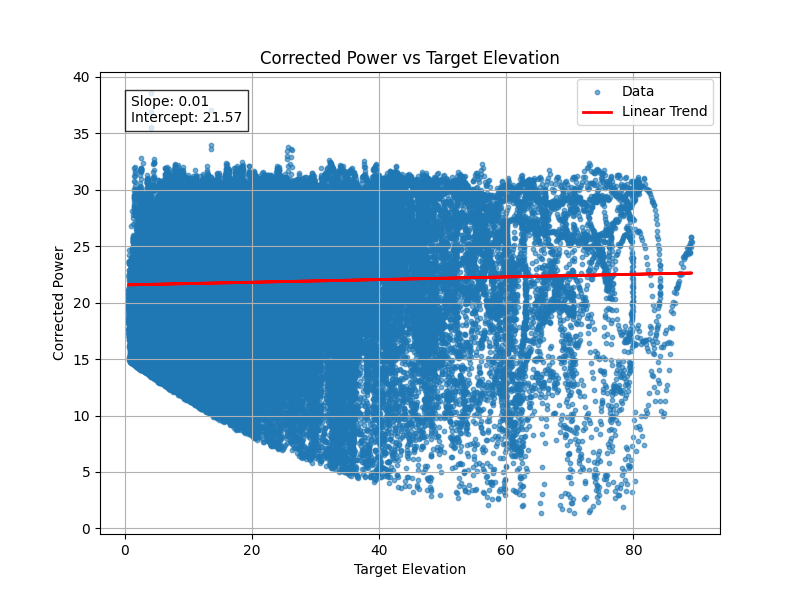

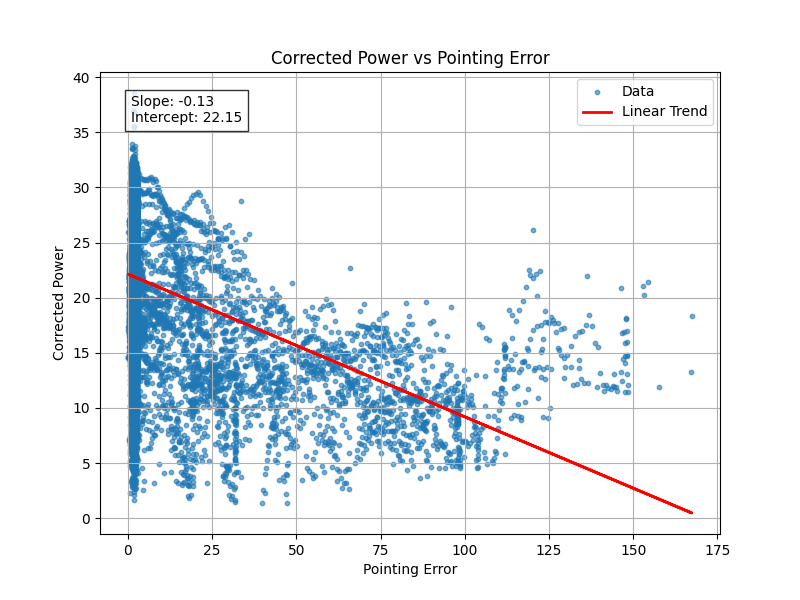

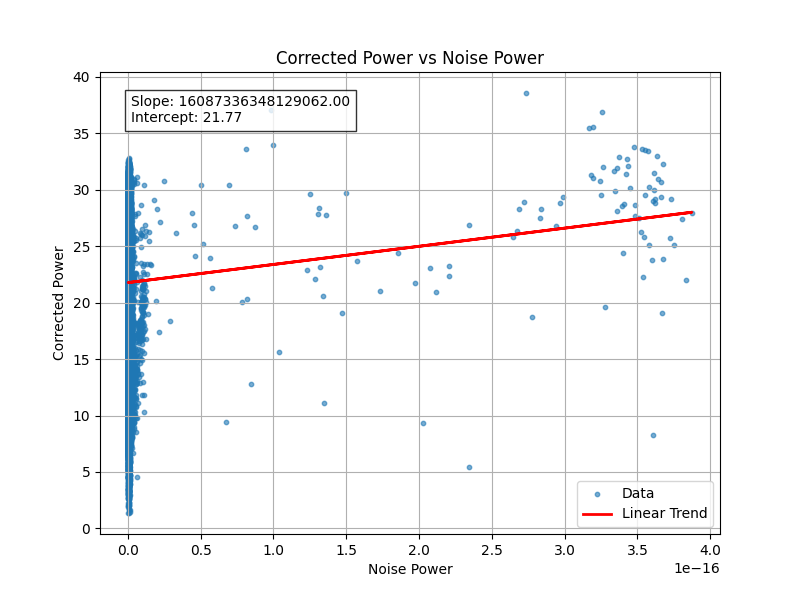

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Feature names for better visualization
feature_names = [
    "Time",                # 0
    "Signal Power",        # 1
    "FSPL",                # 2
    "Distance",            # 3
    "Target Azimuth",      # 4
    "Target Elevation",    # 5
    "Pointing Error",      # 6
    "Noise Power",         # 7
    "Corrected Power"      # 8
]

# Index of corrected power
corrected_power_idx = 8

# Iterate through all features except corrected_power
for idx, feature_name in enumerate(feature_names):
    if idx == corrected_power_idx:
        continue  # Skip corrected power itself

    # Extract the corrected power and the current feature
    corrected_power = BAM[:, corrected_power_idx, :].flatten()
    feature = BAM[:, idx, :].flatten()

    # Filter out NaN values for plotting
    valid_mask = ~np.isnan(corrected_power) & ~np.isnan(feature)
    corrected_power_valid = corrected_power[valid_mask]
    feature_valid = feature[valid_mask]

    # Fit a linear trend line
    if len(corrected_power_valid) > 1:  # Ensure there's enough data for fitting
        slope, intercept = np.polyfit(feature_valid, corrected_power_valid, 1)
        trend_line = slope * feature_valid + intercept
        trend_info = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}"
    else:
        trend_info = "Insufficient data"

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(feature_valid, corrected_power_valid, alpha=0.6, s=10, label="Data")
    if len(corrected_power_valid) > 1:
        plt.plot(feature_valid, trend_line, color="red", linewidth=2, label="Linear Trend")
    plt.xlabel(feature_name)
    plt.ylabel("Corrected Power")
    plt.title(f"Corrected Power vs {feature_name}")

    # Add trendline information as text on the plot
    if len(corrected_power_valid) > 1:
        plt.text(0.05, 0.95, trend_info, transform=plt.gca().transAxes,
                 fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

    plt.legend()
    plt.grid(True)
    plt.show()
